# AIN422 Introduction to Deep Learning Lab
## Assignment 2 : Convolutional Neural Network
#### Student Number: 21992919
##### Student Name/Surname : Melike Nur DULKADİR

**Aim of the Experiment**
- The aim of this assignment is to focus on Convolutional Neural Network (CNN), which is a type of neural network commonly used in image and video recognition, processing and analysis. For this assignment a basic CNN model will be build and then this model will be developed using different methods and techniques.
- The MNIST dataset will be used for this assignment.

Before the assignment is started, the necessary libraries are imported.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import gzip
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

## 1 - Loading the MNIST Dataset Using Custom Data Loader

This code defines a class CustomMNISTDataset that loads the MNIST dataset from the train-images-idx3-ubyte.gz, train-labels-idx1-ubyte.gz, t10k-images-idx3-ubyte.gz, and t10k-labels-idx1-ubyte.gz files. The __load_images_and_labels__ method reads the data from these files and returns the train and test images and labels. The train_size, test_size, and image_size parameters can be used to control the size of the dataset and the dimensions of the images.

In [2]:
class CustomMNISTDataset:
    def __init__(self, train_size = 60000, test_size = 10000, image_size = 28):
        self.train_size = train_size
        self.test_size = test_size
        self.image_size = image_size

    def __load_images_and_labels__(self):
        with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            n_images = int.from_bytes(f.read(4), 'big')
            n_rows = int.from_bytes(f.read(4), 'big')
            n_cols = int.from_bytes(f.read(4), 'big')
            train_images = np.frombuffer(f.read(), dtype=np.uint8).reshape(n_images, n_rows, n_cols)

        with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            n_labels = int.from_bytes(f.read(4), 'big')
            train_labels = np.frombuffer(f.read(), dtype=np.uint8)

        # Load test data
        with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            n_images = int.from_bytes(f.read(4), 'big')
            n_rows = int.from_bytes(f.read(4), 'big')
            n_cols = int.from_bytes(f.read(4), 'big')
            test_images = np.frombuffer(f.read(), dtype=np.uint8).reshape(n_images, n_rows, n_cols)

        with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            n_labels = int.from_bytes(f.read(4), 'big')
            test_labels = np.frombuffer(f.read(), dtype=np.uint8)
        return train_images,train_labels,test_images,test_labels

CustomDataLoader is a class that creates a custom data loader for a given dataset. It takes in the images and labels of the dataset, the desired batch size, and an optional transform function that can be used to apply transformations to the data. It creates an iterable object that generates batches of data and labels when iterated over, by splitting the dataset into batches of the specified size. If the transform function is provided, it is applied to each data item in the batch before it is returned. The length of the data loader is the number of items in the dataset.

In [3]:
class CustomDataLoader:
    def __init__(self, images, labels, batch_size, transform=None):
        self.dataset = [(image, label) for image, label in zip(images, labels)]
        self.batch_size = batch_size
        self.transform = transform

    def __iter__(self):
        batch_data = []
        batch_labels = []
        for data, label in self.dataset:
            if self.transform:
                data = self.transform(data)
            batch_data.append(torch.from_numpy(data))
            batch_labels.append(torch.tensor(label).long())
            if len(batch_data) == self.batch_size:
                yield torch.stack(batch_data), torch.stack(batch_labels)
                batch_data = []
                batch_labels = []
        if len(batch_data) > 0:
            yield torch.stack(batch_data), torch.stack(batch_labels)

    def __len__(self):
        return len(self.dataset)

In [4]:
custom_dataset = CustomMNISTDataset()
train_images, train_labels, test_images, test_labels = custom_dataset.__load_images_and_labels__()

## 2 - Analyzing the Dataset and Preprocessing

Printing first ten images from the dataset will help to clearly understand the dataset.

##### Preprocess Data

In [5]:
train_dataloader = CustomDataLoader(train_images, train_labels, batch_size=32)
test_dataloader = CustomDataLoader(test_images, test_labels, batch_size=32)


# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Split into training and testing sets
train_size = 60000
test_size = 10000

X_train = train_images[:train_size]
y_train = train_labels[:train_size]

X_test = test_images[:test_size]
y_test = test_labels[:test_size]

In [6]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
60000 train samples
10000 test samples


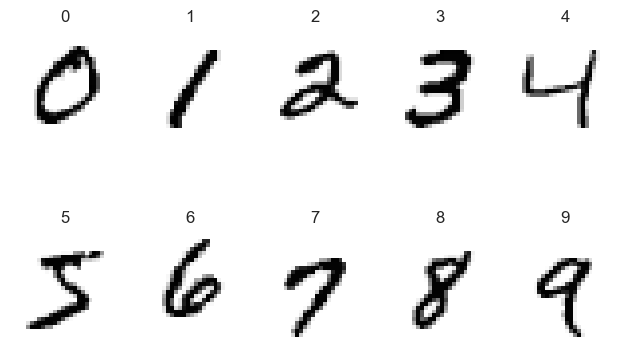

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex= 'all', sharey='all')
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

##### Distribution of Data
As can be seen from the count plots, the dataset has not an equal distribution of labels. However, the sample numbers in the test and train data are proportional to the labels.

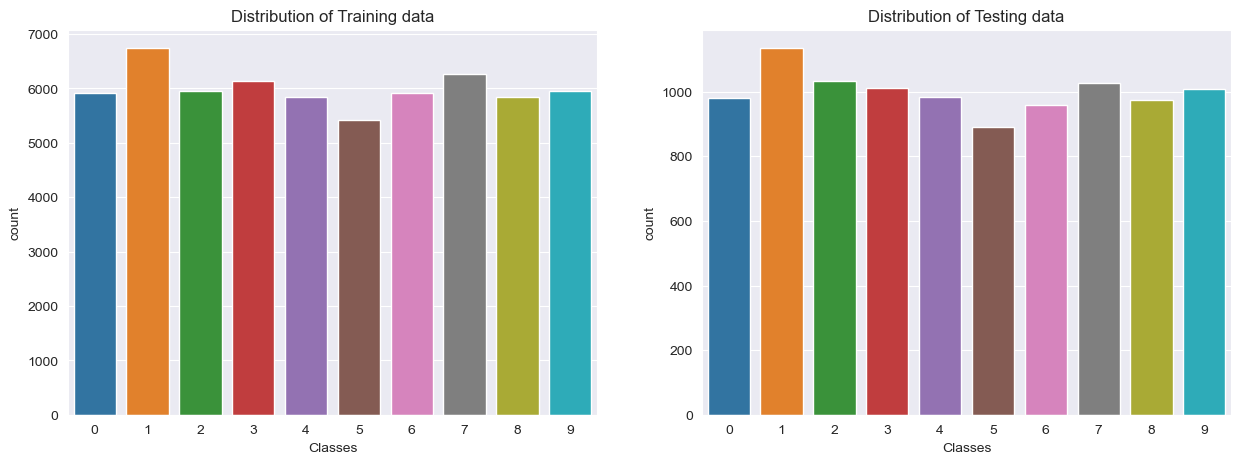

In [8]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# Count plot for training set
sns.countplot(x=y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of Training data')
axs[0].set_xlabel('Classes')

# Count plot for testing set
sns.countplot(x=y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

Bar plot for showing number of images in each class.

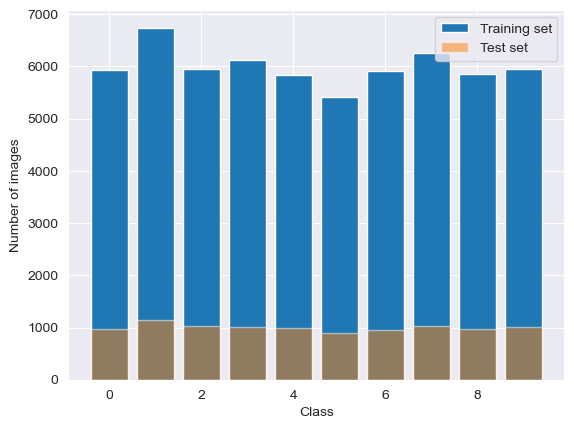

In [9]:
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

fig, ax = plt.subplots()
ax.bar(np.arange(10), train_counts, label='Training set')
ax.bar(np.arange(10), test_counts, label='Test set', alpha=0.5)
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.legend()
plt.show()

##### Histogram of Pixel Intensities
The flatten method is used to transform the 2D images into 1D arrays, so that the pixel intensities can be visualized in a histogram. The histogram shows the distribution of pixel intensities across all the images in the MNIST training set.

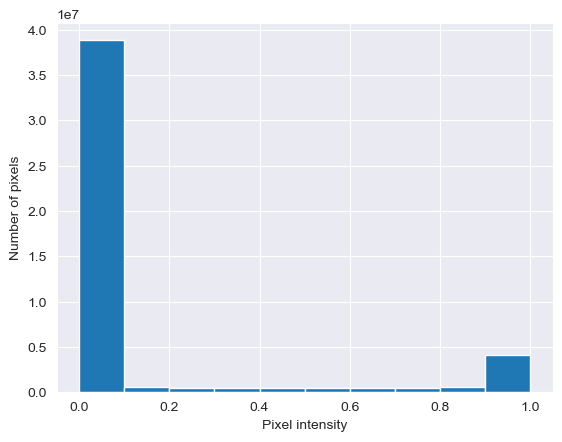

In [10]:
fig, ax = plt.subplots()
ax.hist(X_train.flatten(), bins=10)
ax.set_xlabel('Pixel intensity')
ax.set_ylabel('Number of pixels')
plt.show()

Printing first ten images after preprocessing.

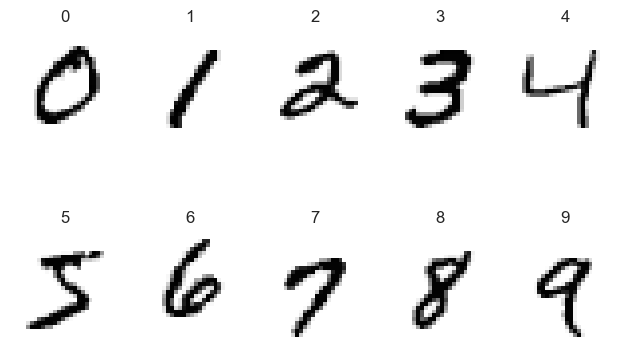

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 3 - Designing Custom CNN

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**in_channels** is a parameter of the nn. Conv2d module in PyTorch, which specifies the number of input channels in the input tensor. For example, in the case of a grayscale image, the input tensor has one channel, so in_channels = 1.
**out_channels** refers to the number of output channels or filters.
**kernel_size** is a hyperparameter that determines the size of the filter used to convolve over the input image.

In [49]:
class MyCNN(nn.Module):
    def __init__(self, out_channels=16, kernel_size=3, stride=1, padding=1):
        super(MyCNN, self).__init__()
        self.out_channels = out_channels
        self.output = (28 - kernel_size + (2*padding)) / stride + 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = (self.output - 2) / 2 + 1
        self.fc1 = nn.Linear(in_features=int(self.output)*int(self.output)*int(self.out_channels), out_features=10)

    def __repr__(self):
        return ""

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Add this line to specify input shape
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = x.view(-1, int(self.output)*int(self.output)*int(self.out_channels))
        x = self.fc1(x)
        return x

This code defines a convolutional neural network architecture with one convolutional layer followed by max pooling and a fully connected layer. The number of output channels, kernel size, stride, and padding of the convolutional layer are adjustable with default values. The input image size is assumed to be 28x28, which is the size of MNIST dataset images.

The \__init__ method initializes the layers of the network. The forward method defines the forward pass of the network, where the input x is processed through the layers sequentially. The ReLU activation function is used after the convolutional layer.

In [18]:
# set epoch hyperparameter
num_epochs = 10

The function trains and evaluates a PyTorch model with specified parameters and prints the classification report if specified.

In [16]:
def train_and_evaluate_model(model, train_dataloader, test_dataloader, parameter_name,i,batch_size,learning_rate,show_classification_report):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    if not i == "":
        print(parameter_name,":",i)

    for epoch in range(num_epochs):

        model.train()

        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Train the model on the training dataset
        for batch_idx, (data, target) in enumerate(train_dataloader):

            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            batch_data = torch.from_numpy(X_train[start_idx:end_idx]).float()
            batch_labels = y_train[start_idx:end_idx]

            data = data.float()
            output = model(batch_data)

            # Calculate the loss
            loss = criterion(output, target)
            train_loss += loss.item() * data.size(0)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_dataloader.dataset)
        train_accuracy = 100 * train_correct / train_total

        # Evaluate the model on the testing dataset
        model.eval()  # Set model to eval mode
        test_correct = 0
        test_total = 0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for data, target in test_dataloader:
                data = data.float()
                output = model(data)

                # Calculate accuracy
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

                true_labels.extend(target.tolist())
                predicted_labels.extend(predicted.tolist())

        # Calculate testing accuracy
        test_accuracy = 100 * test_correct / test_total

        # Print the progress
        print(f"Epoch {epoch+1}, Test Accuracy: {test_accuracy:.4f}")

    if show_classification_report:
        report = classification_report(true_labels, predicted_labels)
        print(report)
    return model


In this function, train accuracy and loss values are also kept, if desired, these values can also be observed.

The code iterates through different values of out_channels for the MyCNN model, trains and evaluates the model for each value of out_channels, and prints the test accuracy for each epoch. The output shows the test accuracy for each epoch of each model trained with a different value of out_channels.

In [36]:
out_channels_values = [16,64,128]
for i in out_channels_values:
    model = MyCNN(out_channels=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "out channel",i,32,0.01,False)

out channel is:  16
Epoch 1, Test Accuracy: 0.9026
out channel is:  16
Epoch 2, Test Accuracy: 0.9135
out channel is:  16
Epoch 3, Test Accuracy: 0.9196
out channel is:  16
Epoch 4, Test Accuracy: 0.9271
out channel is:  16
Epoch 5, Test Accuracy: 0.9339
out channel is:  16
Epoch 6, Test Accuracy: 0.9421
out channel is:  16
Epoch 7, Test Accuracy: 0.9483
out channel is:  16
Epoch 8, Test Accuracy: 0.9552
out channel is:  16
Epoch 9, Test Accuracy: 0.9600
out channel is:  16
Epoch 10, Test Accuracy: 0.9643
out channel is:  64
Epoch 1, Test Accuracy: 0.9185
out channel is:  64
Epoch 2, Test Accuracy: 0.9341
out channel is:  64
Epoch 3, Test Accuracy: 0.9466
out channel is:  64
Epoch 4, Test Accuracy: 0.9564
out channel is:  64
Epoch 5, Test Accuracy: 0.9639
out channel is:  64
Epoch 6, Test Accuracy: 0.9685
out channel is:  64
Epoch 7, Test Accuracy: 0.9719
out channel is:  64
Epoch 8, Test Accuracy: 0.9736
out channel is:  64
Epoch 9, Test Accuracy: 0.9750
out channel is:  64
Epoch 10, 

The highest accuracy achieved is 0.9773 for out_channels = 128. The minimum accuracy achieved is 0.9026 for out_channels = 16. Based on the test accuracies, increasing the number of out_channels appears to improve the performance of the model.

The code iterates through different values of kernel size for the MyCNN model.

In [57]:
kernel_sizes = [3,5,7]
for i in kernel_sizes:
    model = MyCNN(out_channels=128,kernel_size=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "kernel size",i,32,0.01,False)

kernel size : 3
Epoch 1, Test Accuracy: 0.9245
Epoch 2, Test Accuracy: 0.9432
Epoch 3, Test Accuracy: 0.9554
Epoch 4, Test Accuracy: 0.9618
Epoch 5, Test Accuracy: 0.9675
Epoch 6, Test Accuracy: 0.9717
Epoch 7, Test Accuracy: 0.9743
Epoch 8, Test Accuracy: 0.9752
Epoch 9, Test Accuracy: 0.9760
Epoch 10, Test Accuracy: 0.9769
kernel size : 5
Epoch 1, Test Accuracy: 0.9339
Epoch 2, Test Accuracy: 0.9582
Epoch 3, Test Accuracy: 0.9682
Epoch 4, Test Accuracy: 0.9731
Epoch 5, Test Accuracy: 0.9759
Epoch 6, Test Accuracy: 0.9779
Epoch 7, Test Accuracy: 0.9798
Epoch 8, Test Accuracy: 0.9810
Epoch 9, Test Accuracy: 0.9822
Epoch 10, Test Accuracy: 0.9824
kernel size : 7
Epoch 1, Test Accuracy: 0.9365
Epoch 2, Test Accuracy: 0.9593
Epoch 3, Test Accuracy: 0.9692
Epoch 4, Test Accuracy: 0.9735
Epoch 5, Test Accuracy: 0.9772
Epoch 6, Test Accuracy: 0.9798
Epoch 7, Test Accuracy: 0.9820
Epoch 8, Test Accuracy: 0.9826
Epoch 9, Test Accuracy: 0.9833
Epoch 10, Test Accuracy: 0.9839



For the kernel size parameter, the highest accuracy achieved is 0.9839 for kernel size 7 and the lowest accuracy is 0.9245 for kernel size 3. In general, larger kernel sizes tend to perform better than smaller ones, which is consistent with the results we see here.

The code iterates through different values of padding for the MyCNN model.

In [59]:
padding_values = [0, 1, 2]
for i in padding_values:
    model = MyCNN(out_channels=128,kernel_size=7,padding=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader,"padding",i,32,0.01,False)

padding : 0
Epoch 1, Test Accuracy: 0.9379
Epoch 2, Test Accuracy: 0.9604
Epoch 3, Test Accuracy: 0.9702
Epoch 4, Test Accuracy: 0.9749
Epoch 5, Test Accuracy: 0.9781
Epoch 6, Test Accuracy: 0.9808
Epoch 7, Test Accuracy: 0.9824
Epoch 8, Test Accuracy: 0.9829
Epoch 9, Test Accuracy: 0.9833
Epoch 10, Test Accuracy: 0.9842
padding : 1
Epoch 1, Test Accuracy: 0.9389
Epoch 2, Test Accuracy: 0.9604
Epoch 3, Test Accuracy: 0.9710
Epoch 4, Test Accuracy: 0.9760
Epoch 5, Test Accuracy: 0.9794
Epoch 6, Test Accuracy: 0.9814
Epoch 7, Test Accuracy: 0.9828
Epoch 8, Test Accuracy: 0.9832
Epoch 9, Test Accuracy: 0.9834
Epoch 10, Test Accuracy: 0.9842
padding : 2
Epoch 1, Test Accuracy: 0.9365
Epoch 2, Test Accuracy: 0.9593
Epoch 3, Test Accuracy: 0.9687
Epoch 4, Test Accuracy: 0.9743
Epoch 5, Test Accuracy: 0.9770
Epoch 6, Test Accuracy: 0.9795
Epoch 7, Test Accuracy: 0.9820
Epoch 8, Test Accuracy: 0.9836
Epoch 9, Test Accuracy: 0.9845
Epoch 10, Test Accuracy: 0.9849


The highest accuracy achieved is 0.9849 for padding = 2. The minimum accuracy achieved is 0.9365 for padding = 2. Based on the test accuracies, increasing the padding size appears to initially improve the model's performance, but adding more padding beyond a certain point appears to have diminishing returns.

The code iterates through different values of stride for the MyCNN model.

In [60]:
stride_values =  [1, 2]
for i in stride_values:
    model = MyCNN(out_channels=128,kernel_size=7,padding=2,stride=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "stride",i,32,0.01,False)

stride : 1
Epoch 1, Test Accuracy: 0.9388
Epoch 2, Test Accuracy: 0.9601
Epoch 3, Test Accuracy: 0.9710
Epoch 4, Test Accuracy: 0.9759
Epoch 5, Test Accuracy: 0.9796
Epoch 6, Test Accuracy: 0.9814
Epoch 7, Test Accuracy: 0.9830
Epoch 8, Test Accuracy: 0.9837
Epoch 9, Test Accuracy: 0.9841
Epoch 10, Test Accuracy: 0.9845
stride : 2
Epoch 1, Test Accuracy: 0.9308
Epoch 2, Test Accuracy: 0.9510
Epoch 3, Test Accuracy: 0.9609
Epoch 4, Test Accuracy: 0.9679
Epoch 5, Test Accuracy: 0.9724
Epoch 6, Test Accuracy: 0.9748
Epoch 7, Test Accuracy: 0.9772
Epoch 8, Test Accuracy: 0.9782
Epoch 9, Test Accuracy: 0.9790
Epoch 10, Test Accuracy: 0.9804


The highest accuracy achieved is 0.9845 for stride = 1. The minimum accuracy achieved is 0.9308 for stride = 2. Based on the test accuracies, using stride 1 appears to give better results than using stride 2, as the model achieved higher test accuracies when using stride 1.

**According to the accuracy values, the best parameters are: out_channels = 128,kernel_size=7,padding=2,stride=1.**

The code iterates through different values of batch sizes for the MyCNN model.

In [63]:
batch_sizes = [32,64,128]
for i in batch_sizes:
    model = MyCNN(out_channels=128,kernel_size=7,padding=2,stride=1)
    train_and_evaluate_model(model, train_dataloader, test_dataloader,"batch_size",i,i,0.01,False)

batch_size : 32
Epoch 1, Test Accuracy: 0.9387
Epoch 2, Test Accuracy: 0.9609
Epoch 3, Test Accuracy: 0.9713
Epoch 4, Test Accuracy: 0.9748
Epoch 5, Test Accuracy: 0.9786
Epoch 6, Test Accuracy: 0.9808
Epoch 7, Test Accuracy: 0.9826
Epoch 8, Test Accuracy: 0.9840
Epoch 9, Test Accuracy: 0.9842
Epoch 10, Test Accuracy: 0.9845
batch_size : 64
Epoch 1, Test Accuracy: 0.9222
Epoch 2, Test Accuracy: 0.9418
Epoch 3, Test Accuracy: 0.9546
Epoch 4, Test Accuracy: 0.9625
Epoch 5, Test Accuracy: 0.9680
Epoch 6, Test Accuracy: 0.9723
Epoch 7, Test Accuracy: 0.9753
Epoch 8, Test Accuracy: 0.9772
Epoch 9, Test Accuracy: 0.9786
Epoch 10, Test Accuracy: 0.9793
batch_size : 128
Epoch 1, Test Accuracy: 0.9135
Epoch 2, Test Accuracy: 0.9259
Epoch 3, Test Accuracy: 0.9355
Epoch 4, Test Accuracy: 0.9446
Epoch 5, Test Accuracy: 0.9507
Epoch 6, Test Accuracy: 0.9552
Epoch 7, Test Accuracy: 0.9603
Epoch 8, Test Accuracy: 0.9637
Epoch 9, Test Accuracy: 0.9660
Epoch 10, Test Accuracy: 0.9689


The highest accuracy achieved is 0.9845 for batch_size = 32. The minimum accuracy achieved is 0.9135 for batch_size = 128. Based on the test accuracies, increasing the batch size appears to initially improve the model's performance, but increasing the batch size beyond a certain point appears to have diminishing returns.

In [15]:
learning_rates = [0.1, 0.001]
for i in learning_rates:
    model = MyCNN(out_channels=128,kernel_size=7,padding=2,stride=1)
    train_and_evaluate_model(model, train_dataloader, test_dataloader,"learning_rate",i,32,i,False)

learning_rate : 0.1
Epoch 1, Test Accuracy: 0.9791
Epoch 2, Test Accuracy: 0.9842
Epoch 3, Test Accuracy: 0.9856
Epoch 4, Test Accuracy: 0.9867
Epoch 5, Test Accuracy: 0.9873
Epoch 6, Test Accuracy: 0.9882
Epoch 7, Test Accuracy: 0.9885
Epoch 8, Test Accuracy: 0.9886
Epoch 9, Test Accuracy: 0.9889
Epoch 10, Test Accuracy: 0.9889
learning_rate : 0.001
Epoch 1, Test Accuracy: 0.8966
Epoch 2, Test Accuracy: 0.9145
Epoch 3, Test Accuracy: 0.9230
Epoch 4, Test Accuracy: 0.9279
Epoch 5, Test Accuracy: 0.9317
Epoch 6, Test Accuracy: 0.9355
Epoch 7, Test Accuracy: 0.9385
Epoch 8, Test Accuracy: 0.9417
Epoch 9, Test Accuracy: 0.9440
Epoch 10, Test Accuracy: 0.9468


For the learning rate parameter, we can see that using a learning rate of 0.1 resulted in consistently high accuracy across all epochs, with the highest achieved accuracy of 0.9889. On the other hand, using a learning rate of 0.001 resulted in lower accuracies, with the highest accuracy achieved being 0.9468, which is significantly lower than the highest achieved accuracy using a learning rate of 0.1. Therefore, it appears that increasing the learning rate beyond a certain point can lead to improved model performance, while using too low of a learning rate can negatively impact performance.

The final model final_my_cnn_model uses an output channel of 128, kernel size of 7, padding of 2, and stride of 1. With a batch size of 32 and learning rate of 0.1, the model achieves a high test accuracy of 0.9884 after 10 epochs of training. The precision, recall, and F1-score for each class show that the model performs very well on all classes with an overall accuracy of 0.99.

**The classification report provides a more detailed evaluation of the model's performance for each class. It includes precision, recall, and F1-score for each class, as well as the support, which is the number of samples in each class.**

Looking at the precision values, we can see that the model performs very well for most classes, with values ranging from 0.97 to 1.00. This indicates that the model is able to correctly identify most of the positive cases for each class.

The recall values also show good performance for most classes, with values ranging from 0.98 to 1.00. This means that the model is able to correctly identify most of the actual positive cases for each class.

The F1-score values are also high for most classes, with values ranging from 0.98 to 1.00. This indicates that the model has a good balance between precision and recall for each class.

Overall, the classification report shows that the model performs very well for all classes, with high precision, recall, and F1-score values.

In [18]:
final_my_cnn_model = MyCNN(out_channels=128,kernel_size=7,padding=2,stride=1)
train_and_evaluate_model(final_my_cnn_model, train_dataloader, test_dataloader, "","",32,0.1,True)

Epoch 1, Test Accuracy: 0.9783
Epoch 2, Test Accuracy: 0.9839
Epoch 3, Test Accuracy: 0.9848
Epoch 4, Test Accuracy: 0.9863
Epoch 5, Test Accuracy: 0.9873
Epoch 6, Test Accuracy: 0.9879
Epoch 7, Test Accuracy: 0.9878
Epoch 8, Test Accuracy: 0.9880
Epoch 9, Test Accuracy: 0.9883
Epoch 10, Test Accuracy: 0.9884
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      

After finding the best parameters in this architecture, a different architecture was created to improve the architecture.

In [57]:
class MyCNN_2(nn.Module):

    def __init__(self, out_channels=128, kernel_size=7, stride=1, padding=2):
        super(MyCNN_2, self).__init__()

        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.output = ((28 - kernel_size + (2*padding)) / stride) + 1

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = ((self.output - 2 + (2*0)) / 2) + 1

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=kernel_size, stride=stride, padding=padding)
        self.output = ((self.output - kernel_size + (2*padding)) / stride) + 1

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = ((self.output - 2 + (2*0)) / 2) + 1
        self.dropout1 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(in_features=int(self.output)*int(self.output)*int(out_channels*2), out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def __repr__(self):
        return ""

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, int(self.output)*int(self.output)*int(self.out_channels*2))
        x = self.dropout1(x)
        x = self.fc1(x)

        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

- In this new architecture, another convolutional layer was added, followed by a second max pooling layer. Two dropout layers were then added to prevent overfitting. Finally, a second fully connected layer with 64 hidden units was added before the final output layer.
- The values of 0.2 and 0.5 are common choices for dropout rates in neural networks. The idea behind dropout is to randomly drop out a proportion of the neurons in each layer during training to prevent overfitting. The dropout rate determines the proportion of neurons that are dropped out, so a higher dropout rate means that more neurons are dropped out.
- A dropout rate of 0.2 means that 20% of the neurons are dropped out during training, and a dropout rate of 0.5 means that 50% of the neurons are dropped out during training. These values have been found to work well in practice for many different types of neural networks, but the optimal dropout rate can vary depending on the architecture and the task at hand.

After the best parameters found earlier were placed as default, other parameters were tried in turn and accuracy values were observed.

In [21]:
out_channels_values =  [32, 64]
for i in out_channels_values:
    model = MyCNN_2(out_channels=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "out channel",i,32,0.1,False)

out channel : 32
Epoch 1, Test Accuracy: 0.9815
Epoch 2, Test Accuracy: 0.9855
Epoch 3, Test Accuracy: 0.9900
Epoch 4, Test Accuracy: 0.9882
Epoch 5, Test Accuracy: 0.9903
Epoch 6, Test Accuracy: 0.9908
Epoch 7, Test Accuracy: 0.9925
Epoch 8, Test Accuracy: 0.9906
Epoch 9, Test Accuracy: 0.9917
Epoch 10, Test Accuracy: 0.9924
out channel : 64
Epoch 1, Test Accuracy: 0.9834
Epoch 2, Test Accuracy: 0.9884
Epoch 3, Test Accuracy: 0.9901
Epoch 4, Test Accuracy: 0.9905
Epoch 5, Test Accuracy: 0.9927
Epoch 6, Test Accuracy: 0.9929
Epoch 7, Test Accuracy: 0.9920
Epoch 8, Test Accuracy: 0.9930
Epoch 9, Test Accuracy: 0.9897
Epoch 10, Test Accuracy: 0.9925


It can be seen that the model with out_channels=64 achieves higher test accuracy than the model with out_channels=32. This suggests that increasing the number of output channels may improve the model's performance. However, it's important to note that this comparison only holds for the specific configuration of hyperparameters used in this experiment, and may not be generalizable to other hyperparameter settings.

In [23]:
kernel_sizes = [3, 5]
for i in kernel_sizes:
    model = MyCNN_2(out_channels=32,kernel_size=i)
    train_and_evaluate_model(model,  train_dataloader, test_dataloader,"kernel size",i,32,0.1,False)

kernel size : 3
Epoch 1, Test Accuracy: 0.9785
Epoch 2, Test Accuracy: 0.9839
Epoch 3, Test Accuracy: 0.9847
Epoch 4, Test Accuracy: 0.9883
Epoch 5, Test Accuracy: 0.9893
Epoch 6, Test Accuracy: 0.9895
Epoch 7, Test Accuracy: 0.9904
Epoch 8, Test Accuracy: 0.9900
Epoch 9, Test Accuracy: 0.9914
Epoch 10, Test Accuracy: 0.9920
kernel size : 5
Epoch 1, Test Accuracy: 0.9804
Epoch 2, Test Accuracy: 0.9881
Epoch 3, Test Accuracy: 0.9884
Epoch 4, Test Accuracy: 0.9912
Epoch 5, Test Accuracy: 0.9907
Epoch 6, Test Accuracy: 0.9919
Epoch 7, Test Accuracy: 0.9920
Epoch 8, Test Accuracy: 0.9921
Epoch 9, Test Accuracy: 0.9927
Epoch 10, Test Accuracy: 0.9919


The two sets of experiments were conducted to evaluate the effect of different kernel sizes on the performance of the CNN model. The first experiment used a kernel size of 3, with the highest accuracy of 0.9920 achieved in the 10th epoch, while the second experiment used a kernel size of 5, with the highest accuracy of 0.9927 achieved in the 9th epoch. Overall, the results indicate that a larger kernel size may improve the model's performance slightly, but the difference is relatively small.

In [25]:
padding_values = [1, 2]
for i in padding_values:
    model = MyCNN_2(out_channels=32,kernel_size=3,padding = i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "padding",i,32,0.1,False)

padding : 1
Epoch 1, Test Accuracy: 0.9780
Epoch 2, Test Accuracy: 0.9854
Epoch 3, Test Accuracy: 0.9870
Epoch 4, Test Accuracy: 0.9872
Epoch 5, Test Accuracy: 0.9886
Epoch 6, Test Accuracy: 0.9884
Epoch 7, Test Accuracy: 0.9894
Epoch 8, Test Accuracy: 0.9914
Epoch 9, Test Accuracy: 0.9900
Epoch 10, Test Accuracy: 0.9902
padding : 2
Epoch 1, Test Accuracy: 0.9780
Epoch 2, Test Accuracy: 0.9856
Epoch 3, Test Accuracy: 0.9852
Epoch 4, Test Accuracy: 0.9882
Epoch 5, Test Accuracy: 0.9884
Epoch 6, Test Accuracy: 0.9893
Epoch 7, Test Accuracy: 0.9895
Epoch 8, Test Accuracy: 0.9911
Epoch 9, Test Accuracy: 0.9902
Epoch 10, Test Accuracy: 0.9892


The two sets of experiments were conducted to evaluate the effect of different padding values on the performance of the CNN model. The first experiment used a padding of 1, with the highest accuracy of 0.9914 achieved in the 8th epoch, while the second experiment used a padding of 2, with the highest accuracy of 0.9902 achieved in the 9th epoch. Overall, the results indicate that a smaller padding may improve the model's performance slightly, but the difference is relatively small.

In [27]:
stride_values = [1, 2]
for i in stride_values:
    model = MyCNN_2(out_channels = 32,kernel_size = 3,padding = 1,stride = i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader,"stride",i,32,0.1,False)

stride : 1
Epoch 1, Test Accuracy: 0.9774
Epoch 2, Test Accuracy: 0.9850
Epoch 3, Test Accuracy: 0.9876
Epoch 4, Test Accuracy: 0.9880
Epoch 5, Test Accuracy: 0.9899
Epoch 6, Test Accuracy: 0.9900
Epoch 7, Test Accuracy: 0.9906
Epoch 8, Test Accuracy: 0.9906
Epoch 9, Test Accuracy: 0.9906
Epoch 10, Test Accuracy: 0.9913
stride : 2
Epoch 1, Test Accuracy: 0.9649
Epoch 2, Test Accuracy: 0.9771
Epoch 3, Test Accuracy: 0.9786
Epoch 4, Test Accuracy: 0.9831
Epoch 5, Test Accuracy: 0.9827
Epoch 6, Test Accuracy: 0.9843
Epoch 7, Test Accuracy: 0.9849
Epoch 8, Test Accuracy: 0.9866
Epoch 9, Test Accuracy: 0.9864
Epoch 10, Test Accuracy: 0.9859


The two sets of experiments were conducted to evaluate the effect of different stride values on the performance of the CNN model. The first experiment used a stride of 1, with the highest accuracy of 0.9913 achieved in the 10th epoch, while the second experiment used a stride of 2, with the highest accuracy of 0.9866 achieved in the 8th epoch. Overall, the results indicate that a smaller stride may improve the model's performance slightly.

In [28]:
batch_sizes = [32, 64]
for i in batch_sizes:
    model = MyCNN_2(out_channels = 32,kernel_size = 3,padding = 1,stride = 1)
    train_and_evaluate_model(model, train_dataloader, test_dataloader,"batch size",i,i,0.1,False)

batch size : 32
Epoch 1, Test Accuracy: 0.9742
Epoch 2, Test Accuracy: 0.9847
Epoch 3, Test Accuracy: 0.9863
Epoch 4, Test Accuracy: 0.9877
Epoch 5, Test Accuracy: 0.9900
Epoch 6, Test Accuracy: 0.9893
Epoch 7, Test Accuracy: 0.9913
Epoch 8, Test Accuracy: 0.9918
Epoch 9, Test Accuracy: 0.9909
Epoch 10, Test Accuracy: 0.9913
batch size : 64
Epoch 1, Test Accuracy: 0.9737
Epoch 2, Test Accuracy: 0.9816
Epoch 3, Test Accuracy: 0.9841
Epoch 4, Test Accuracy: 0.9871
Epoch 5, Test Accuracy: 0.9869
Epoch 6, Test Accuracy: 0.9891
Epoch 7, Test Accuracy: 0.9901
Epoch 8, Test Accuracy: 0.9897
Epoch 9, Test Accuracy: 0.9903
Epoch 10, Test Accuracy: 0.9905


The two sets of experiments were conducted to evaluate the effect of different kernel sizes on the performance of the CNN model. The first experiment used a batch size of 32, with the highest accuracy of 0.9913 achieved in the 10th epoch, while the second experiment used a kernel size of 64, with the highest accuracy of 0.9905 achieved in the 10th epoch. Overall, the results indicate that a smaller batch size may improve the model's performance slightly, but the difference is relatively small.


In [30]:
learning_rates = [0.01]
for i in learning_rates:
    model = MyCNN_2(out_channels=32,kernel_size=3,padding = 1,stride = 1)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "learning rate",i,32,i,False)

learning rate : 0.01
Epoch 1, Test Accuracy: 0.9209
Epoch 2, Test Accuracy: 0.9561
Epoch 3, Test Accuracy: 0.9661
Epoch 4, Test Accuracy: 0.9724
Epoch 5, Test Accuracy: 0.9775
Epoch 6, Test Accuracy: 0.9792
Epoch 7, Test Accuracy: 0.9812
Epoch 8, Test Accuracy: 0.9834
Epoch 9, Test Accuracy: 0.9834
Epoch 10, Test Accuracy: 0.9849


Since learning rate = 0.1 was tried by default in all other experiments, only 0.01 was tried here. According to the results, it was seen that the better learning rate provides higher accuracy values.

The final model, MyCNN_2, has a total of 6 layers, with 2 convolutional layers, 2 max pooling layers, 2 dropout layers, and 2 fully connected layers. The model has 32 output channels, a kernel size of 3, a padding of 1, and a stride of 1. The dropout rate is set to 0.1, which means that 10% of the neurons are randomly dropped out during training.

In [60]:
final_my_cnn_2_model = MyCNN_2(out_channels = 32,kernel_size = 3,padding = 1,stride = 1)
train_and_evaluate_model(final_my_cnn_2_model, train_dataloader, test_dataloader,"","",32,0.1,True)

Epoch 1, Test Accuracy: 98.2400
Epoch 2, Test Accuracy: 98.7000
Epoch 3, Test Accuracy: 98.7400
Epoch 4, Test Accuracy: 99.0400
Epoch 5, Test Accuracy: 99.0900
Epoch 6, Test Accuracy: 99.0300
Epoch 7, Test Accuracy: 99.0200
Epoch 8, Test Accuracy: 99.2400
Epoch 9, Test Accuracy: 99.2800
Epoch 10, Test Accuracy: 99.2000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      

The final model achieves a very high accuracy of 99.2% on the test set, indicating that it is performing very well on the task of classifying handwritten digits. The precision, recall, and F1-score for each class are also very high, with most of them being 1.0, indicating that the model is performing well for each individual class. The macro-average and weighted-average F1-scores are also very high, indicating that the model is performing well across all classes.

In [77]:
class MyCNN_3(nn.Module):

    def __init__(self, out_channels=32, kernel_size=5, stride=1, padding=2):
        super(MyCNN_3, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.output = ((28 - kernel_size + (2*padding)) / stride) + 1
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = ((self.output - 2 + (2*0)) / 2) + 1
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=kernel_size, stride=stride, padding=padding)
        self.output = ((self.output - kernel_size + (2*padding)) / stride) + 1
        self.batchnorm2 = nn.BatchNorm2d(out_channels*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = ((self.output - 2 + (2*0)) / 2) + 1
        self.conv3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels*4, kernel_size=kernel_size, stride=stride, padding=padding)
        self.output = ((self.output - kernel_size + (2*padding)) / stride) + 1
        self.batchnorm3 = nn.BatchNorm2d(out_channels*4)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(in_features=int(self.output)*int(self.output)*int(out_channels*4), out_features=256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def __repr__(self):
        return ""

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.batchnorm3(x)
        x = x.view(-1, int(self.output)*int(self.output)*int(self.out_channels*4))
        x = self.dropout1(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

 In the MyCNN_3 architecture, three convolutional layers were added, each followed by a max pooling layer and batch normalization. A dropout layer was also added after the third convolutional layer to prevent overfitting. Two fully connected layers were included, the first with 256 hidden units and the second with 10 output units. Dropout rates of 0.3 and 0.5 were used, respectively, for the two dropout layers. These dropout rates were chosen based on common practice in neural network training, where higher rates are used for deeper architectures to prevent overfitting, and the optimal rate can vary depending on the specific task and architecture.

In [72]:
out_channels_values =  [32, 64]
for i in out_channels_values:
    model = MyCNN_3(out_channels=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "out channel",i,32,0.1,False)

out channel : 32
Epoch 1, Test Accuracy: 66.4100
Epoch 2, Test Accuracy: 82.2700
Epoch 3, Test Accuracy: 78.0700
Epoch 4, Test Accuracy: 88.2000
Epoch 5, Test Accuracy: 85.8500
Epoch 6, Test Accuracy: 86.2200
Epoch 7, Test Accuracy: 85.3600
Epoch 8, Test Accuracy: 79.0900
Epoch 9, Test Accuracy: 85.7900
Epoch 10, Test Accuracy: 86.8500
out channel : 64
Epoch 1, Test Accuracy: 78.2300
Epoch 2, Test Accuracy: 82.3200
Epoch 3, Test Accuracy: 82.8300
Epoch 4, Test Accuracy: 82.8200
Epoch 5, Test Accuracy: 84.0200
Epoch 6, Test Accuracy: 81.8700
Epoch 7, Test Accuracy: 86.4700
Epoch 8, Test Accuracy: 84.5900
Epoch 9, Test Accuracy: 80.6400
Epoch 10, Test Accuracy: 77.0500


I have tried 2 different out_channels_values for this architecture. However, as seen above accuracy values are too low. There could be several reasons why the accuracy is low with this architecture. Here are some possible reasons:

- Overfitting: It's possible that the model is overfitting to the training data and not generalizing well to the test data.

- Learning rate: If the learning rate is too high, the model may not converge well, and if the learning rate is too low, it may take longer to converge.

- Model complexity: The model may not be complex enough to learn the patterns in the data.


##### Extra CNN to Avoid Overfitting

In [15]:
class MyCNN_4(nn.Module):

    def __init__(self, out_channels=16, kernel_size=3, stride=1, padding=1):
        super(MyCNN_4, self).__init__()
        self.out_channels = out_channels
        self.output = (28 - kernel_size + (2*padding)) / stride + 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output = (self.output - 2) / 2 + 1

        self.dropout1 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(in_features=int(self.output)*int(self.output)*int(self.out_channels), out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def __repr__(self):
        return ""

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Add this line to specify input shape
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = x.view(-1, int(self.output)*int(self.output)*int(self.out_channels))

        x = self.dropout1(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


The architecture MyCNN_4 is a convolutional neural network that is designed for classification tasks on 28x28 grayscale images. It consists of a single convolutional layer, a max-pooling layer, two fully connected layers, and dropout layers for regularization. The second pooling layer has been removed and replaced it with a dropout layer to help prevent overfitting. Another dropout layer has been added  before the second fully connected layer.

In [95]:
out_channels_values =  [32, 64]
for i in out_channels_values:
    model = MyCNN_4(out_channels=i)
    train_and_evaluate_model(model, train_dataloader, test_dataloader, "out channel",i,32,0.1,False)

out channel : 32
Epoch 1, Test Accuracy: 88.5300
Epoch 2, Test Accuracy: 88.8400
Epoch 3, Test Accuracy: 80.4700
Epoch 4, Test Accuracy: 73.3800
Epoch 5, Test Accuracy: 68.9000
Epoch 6, Test Accuracy: 67.0800
Epoch 7, Test Accuracy: 65.9800
Epoch 8, Test Accuracy: 62.4700
Epoch 9, Test Accuracy: 63.4600
Epoch 10, Test Accuracy: 59.1400
out channel : 64
Epoch 1, Test Accuracy: 89.8100
Epoch 2, Test Accuracy: 85.4400
Epoch 3, Test Accuracy: 76.5600
Epoch 4, Test Accuracy: 74.7600
Epoch 5, Test Accuracy: 69.7000
Epoch 6, Test Accuracy: 70.0300
Epoch 7, Test Accuracy: 66.2000
Epoch 8, Test Accuracy: 68.5400
Epoch 9, Test Accuracy: 63.7200
Epoch 10, Test Accuracy: 59.0900



Looping through different values of out_channels which are 32 and 64 in this case, and creating instances of MyCNN_4 model with each value. Then, it calls the train_and_evaluate_model function to train and evaluate the model for each out_channels value.
Looking at the output, it shows the test accuracy of the model for each epoch during training. It seems that the model with out_channels of 32 achieved a higher accuracy than the one with 64 in the earlier epochs, but the latter caught up in later epochs.

In [96]:
model = MyCNN_4(out_channels=32,kernel_size=5)
train_and_evaluate_model(model,  train_dataloader, test_dataloader,"kernel size",5,32,0.1,False)

kernel size : 5
Epoch 1, Test Accuracy: 91.9700
Epoch 2, Test Accuracy: 92.8800
Epoch 3, Test Accuracy: 93.0700
Epoch 4, Test Accuracy: 92.6300
Epoch 5, Test Accuracy: 91.2900
Epoch 6, Test Accuracy: 91.6100
Epoch 7, Test Accuracy: 92.3600
Epoch 8, Test Accuracy: 90.6500
Epoch 9, Test Accuracy: 92.1400
Epoch 10, Test Accuracy: 91.7000


Since the value of 3 has been tried in other experiments, only the value of 5 is tried for kernel_size this time. The results show that the accuracy is generally highest for kernel_size=5 but kernel_size=3 is still performing well.

In [98]:
model = MyCNN_4(out_channels=32,kernel_size=5,padding = 2)
train_and_evaluate_model(model, train_dataloader, test_dataloader, "padding",2,32,0.1,False)

padding : 2
Epoch 1, Test Accuracy: 93.5000
Epoch 2, Test Accuracy: 95.7500
Epoch 3, Test Accuracy: 96.4100
Epoch 4, Test Accuracy: 96.5700
Epoch 5, Test Accuracy: 96.5000
Epoch 6, Test Accuracy: 96.1500
Epoch 7, Test Accuracy: 96.4900
Epoch 8, Test Accuracy: 96.1800
Epoch 9, Test Accuracy: 95.5000
Epoch 10, Test Accuracy: 95.5700


Since the value of 1 has been tried in other experiments, only the value of 2 is tried for padding this time. The results show that the accuracy is generally highest for padding=2 than padding=1.

In [99]:
model = MyCNN_4(out_channels = 32,kernel_size = 5,padding = 2,stride = 2)
train_and_evaluate_model(model, train_dataloader, test_dataloader,"stride",2,32,0.1,False)

stride : 2
Epoch 1, Test Accuracy: 92.7800
Epoch 2, Test Accuracy: 94.2700
Epoch 3, Test Accuracy: 92.9300
Epoch 4, Test Accuracy: 92.9300
Epoch 5, Test Accuracy: 92.9400
Epoch 6, Test Accuracy: 89.5500
Epoch 7, Test Accuracy: 90.8500
Epoch 8, Test Accuracy: 89.4300
Epoch 9, Test Accuracy: 91.4200
Epoch 10, Test Accuracy: 90.9400


Since the value of 1 has been tried in other experiments, only the value of 2 is tried for stride this time. The results show that the accuracy is generally highest for stride=1.

In [19]:
model = MyCNN_4(out_channels=32,kernel_size=5,padding = 2,stride = 1)
train_and_evaluate_model(model, train_dataloader, test_dataloader, "learning rate",0.01,32,0.01,False)

learning rate : 0.01
Epoch 1, Test Accuracy: 87.4900
Epoch 2, Test Accuracy: 89.4900
Epoch 3, Test Accuracy: 90.3300
Epoch 4, Test Accuracy: 91.4200
Epoch 5, Test Accuracy: 91.7900
Epoch 6, Test Accuracy: 92.5600
Epoch 7, Test Accuracy: 92.2200
Epoch 8, Test Accuracy: 92.8500
Epoch 9, Test Accuracy: 93.2900
Epoch 10, Test Accuracy: 93.4500


32 and 64 for out_channels_values, 3 and 5 for kernel size, 1 and 2 for padding and stride values, 0.01 and 0.1 for learning rate were tried. The best results were determined as out_channels=32,kernel_size=5,padding = 2,stride = 1, learning rate= 0.1 values and a final model was created with these parameters.

In [21]:
final_my_cnn_4_model = MyCNN_4(out_channels=32,kernel_size=5,padding = 2,stride = 1)
train_and_evaluate_model(final_my_cnn_4_model, train_dataloader, test_dataloader, "", "", 32, 0.1, True)

Epoch 1, Test Accuracy: 94.0700
Epoch 2, Test Accuracy: 95.5400
Epoch 3, Test Accuracy: 95.4200
Epoch 4, Test Accuracy: 94.7500
Epoch 5, Test Accuracy: 95.1800
Epoch 6, Test Accuracy: 94.7000
Epoch 7, Test Accuracy: 94.5300
Epoch 8, Test Accuracy: 94.2900
Epoch 9, Test Accuracy: 94.1300
Epoch 10, Test Accuracy: 92.9600
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00      0.93      0.97      1135
           2       0.99      0.92      0.95      1032
           3       0.99      0.87      0.93      1010
           4       0.99      0.98      0.99       982
           5       1.00      0.75      0.86       892
           6       0.98      0.97      0.98       958
           7       0.99      0.94      0.97      1028
           8       0.62      1.00      0.76       974
           9       0.97      0.92      0.95      1009

    accuracy                           0.93     10000
   macro avg       0.95      

## Conclusion

This assignment investigates the effect of different CNN architectures and hyperparameters on image classification accuracy using the MNIST dataset. The results show that increasing or decreasing certain parameters can improve accuracy rates, but increasing hyperparameters also increases model complexity and training time. One architecture exhibited overfitting, emphasizing the need for regularization techniques. Additionally, creating custom data loaders can be crucial for handling large datasets and custom transformations. Overall, all tasks highlights the importance of properly tuning hyperparameters and implementing regularization techniques for improving CNN model performance in image classification tasks.